# **RNN Exercise**

**BASIC LIBRARIES**

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\GCBA\anaconda3.1\envs\DL\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\GCBA\anaconda3.1\envs\DL\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\GCBA\anaconda3.1\envs\DL\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

# Project Tasks

**Read in the data set "Frozen_Dessert_Production.csv" from the Data folder. Set the date to a datetime index columns**

In [2]:
df = pd.read_csv('../DATA/Frozen_Dessert_Production.csv',parse_dates=True, index_col='DATE')
#    infer_datetime_format=False,)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [4]:
df.rename(columns={'sales': 'Production'}, inplace=True)

In [5]:
df

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


**Plot of time series**

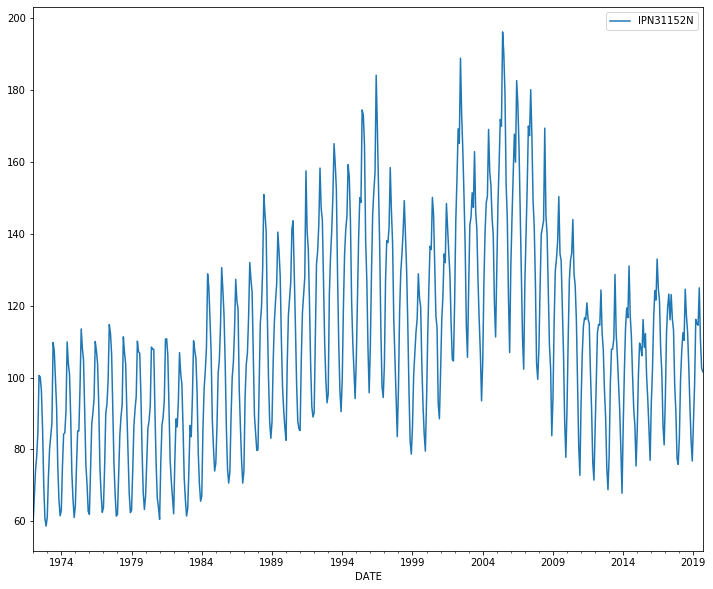

In [7]:
df.plot(figsize=(12,10));

## Train Test Split

**Length of the data set**

In [8]:
len(df)

573

**Split the data into a train/test split where the test set is the last 24 months of data.**

In [9]:
length = 24

In [10]:
x_train = df.iloc[:len(df)-length]

In [11]:
len(x_train)

549

In [12]:
x_test = df.iloc[len(df)-length:]

In [13]:
len(x_test)

24

## Scale Data

**MinMaxScaler to scale the train and test sets into scaled versions.**

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()

In [16]:
x_train = scaler.fit_transform(x_train)

In [17]:
x_test = scaler.transform(x_test)

# Time Series Generator

**A TimeSeriesGenerator object based off the scaled_train data. The batch length can be changed, but as a minimum it should be at least 18 to capture a full year seasonality.**

In [18]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [19]:
generator = TimeseriesGenerator(x_train, x_train, length=18, batch_size=1)

### Create the Model

**Creates a Keras Sequential Model with n LSTM layers and a final Dense Layer.**

In [20]:
from tensorflow.keras.models import Sequential

In [21]:
from tensorflow.keras.layers import Flatten, Dense, LSTM

In [22]:
#create the model
model = Sequential()

#add first layer
model.add(LSTM(100,input_shape=(18,1)))

#add last layer
model.add(Dense(1))

#compile
model.compile(optimizer='adam',
    loss='mse')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


**Generator for the scaled test/validation set.**

In [28]:
val_generator = TimeseriesGenerator(x_test, x_test, length=18, batch_size=1)

**EarlyStopping callback based on val_loss.**

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

In [38]:
early_stop = EarlyStopping(monitor='val_loss', patience=4)

**Fit the model to the generator.The EarlyStopping dictates the amount of epochs, so epochs parameter can be high.**

In [39]:
model.fit_generator(generator,
    steps_per_epoch=None,
    epochs=20,
    verbose=1,
    callbacks=[early_stop],
    validation_data=val_generator)

Epoch 1/20
531/531 [==============================] - 30s 56ms/step - loss: 0.0030 - val_loss: 0.0040
Epoch 2/20
531/531 [==============================] - 29s 55ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 3/20
531/531 [==============================] - 29s 55ms/step - loss: 0.0029 - val_loss: 0.0065
Epoch 4/20
531/531 [==============================] - 29s 55ms/step - loss: 0.0030 - val_loss: 0.0073
Epoch 5/20
531/531 [==============================] - 29s 55ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 6/20
531/531 [==============================] - 29s 55ms/step - loss: 0.0029 - val_loss: 0.0025


**Plot of the history of the loss that occured during training.**

In [40]:
loss = pd.DataFrame(model.history.history)

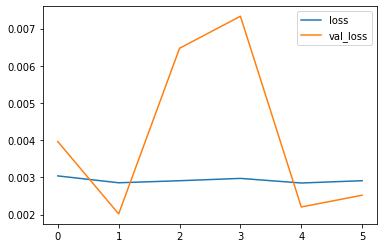

In [41]:
loss.plot()

## Evaluate on Test Data

**Forecast predictions for test data range (the last 24 months of the entire dataset).
Scaling transformation is reverser to evaluate.
Final result is a DataFrame with two columns, the true test values and the predictions.**

In [43]:
#create empty list to be appended with prediction as they are procured
test_predictions = []

first_batch = x_train[-18:]
current_batch = first_batch.reshape((1, 18, 1))

for i in range(len(x_test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [47]:
y_pred = scaler.inverse_transform(test_predictions)

In [48]:
y_pred

array([[ 90.01137091],
       [ 84.76868716],
       [ 85.20813255],
       [ 91.87065752],
       [101.12768401],
       [110.01118314],
       [116.52270255],
       [120.07475634],
       [119.686711  ],
       [114.72304524],
       [105.88121284],
       [ 95.26318962],
       [ 85.75161569],
       [ 80.86398036],
       [ 82.066273  ],
       [ 89.27905755],
       [ 98.83680832],
       [107.80467779],
       [114.16110364],
       [117.31816969],
       [116.73849914],
       [112.06173431],
       [103.62968429],
       [ 92.96334495]])

In [52]:
df_aux = df.iloc[len(df)-24:].copy()

In [53]:
df_aux['y_pred'] = y_pred

In [60]:
df_aux.rename(columns={'IPN31152N': 'Production', 'y_pred': 'est_Production'}, inplace=True)

In [61]:
df_aux

,Production,est_Production
DATE,,
2017-10-01,90.4732,90.011371
2017-11-01,77.4378,84.768687
2017-12-01,75.8118,85.208133
2018-01-01,83.4343,91.870658
2018-02-01,99.4899,101.127684
2018-03-01,107.3152,110.011183
2018-04-01,112.4309,116.522703
2018-05-01,110.3544,120.074756
2018-06-01,124.5841,119.686711


**Plot of predictions versus the True test values.**

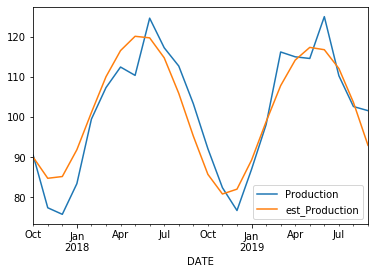

In [63]:
df_aux.plot();

**RMSE calculation.**

In [64]:
from sklearn.metrics import mean_squared_error

In [66]:
RMSE = np.around(np.sqrt(mean_squared_error(df_aux.Production, df_aux.est_Production)),2)

In [67]:
RMSE

5.69